# Project - Windspeed Analysis

Author: Céaman Collins

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

## Importing Data

In [2]:
mace_head = pd.read_csv('data/hly275.csv', parse_dates=['date'], index_col='date', skiprows=17)

C:\Users\luxxx\AppData\Local\Temp\ipykernel_24076\2235875065.py:1: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  mace_head = pd.read_csv('data/hly275.csv', parse_dates=['date'], index_col='date', skiprows=17)
C:\Users\luxxx\AppData\Local\Temp\ipykernel_24076\2235875065.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mace_head = pd.read_csv('data/hly275.csv', parse_dates=['date'], index_col='date', skiprows=17)


In [3]:
mace_head.head()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
date,,,,,,,,,,,,,,
2003-08-13 01:00:00,-1,,4,,4,,,,,,7,,7,
2003-08-13 02:00:00,-1,,4,,4,,,,,,7,,7,
2003-08-13 03:00:00,-1,,4,,4,,,,,,7,,7,
2003-08-13 04:00:00,-1,,4,,4,,,,,,7,,7,
2003-08-13 05:00:00,-1,,4,,4,,,,,,7,,7,


## Cleaning Data

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
mace_head.replace(to_replace=' ', value=np.nan, inplace=True)

In [5]:
mace_head.head()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
date,,,,,,,,,,,,,,
2003-08-13 01:00:00,-1,NaN,4,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,7,NaN
2003-08-13 02:00:00,-1,NaN,4,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,7,NaN
2003-08-13 03:00:00,-1,NaN,4,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,7,NaN
2003-08-13 04:00:00,-1,NaN,4,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,7,NaN
2003-08-13 05:00:00,-1,NaN,4,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,7,NaN


In [6]:
mace_head.dropna(inplace=True)

In [7]:
mace_head.head()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
date,,,,,,,,,,,,,,
2003-08-14 01:00:00,0,0.0,0,10.9,0,9.9,8.9,11.4,87,1024.2,2,6,2,70
2003-08-14 02:00:00,0,0.0,0,10.7,0,9.6,8.5,11.1,86,1024.0,2,4,2,80
2003-08-14 03:00:00,0,0.0,0,10.2,0,9.1,8.0,10.7,86,1024.0,2,3,2,60
2003-08-14 04:00:00,0,0.0,0,9.5,0,8.7,7.9,10.7,90,1023.8,2,5,2,70
2003-08-14 05:00:00,0,0.0,0,9.2,0,8.6,8.0,10.7,92,1023.7,2,6,2,80


In [8]:
mace_head['wdsp'] = pd.to_numeric(mace_head['wdsp'])

## Calculating monthly mean windspeed

In [9]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
mace_head_wdsp_resampled = mace_head['wdsp'].resample('MS').mean()

In [10]:
mace_head_wdsp_resampled.tail()

date
2025-07-01    12.540323
2025-08-01    13.763441
2025-09-01    17.184722
2025-10-01    17.491935
2025-11-01    18.000000
Freq: MS, Name: wdsp, dtype: float64

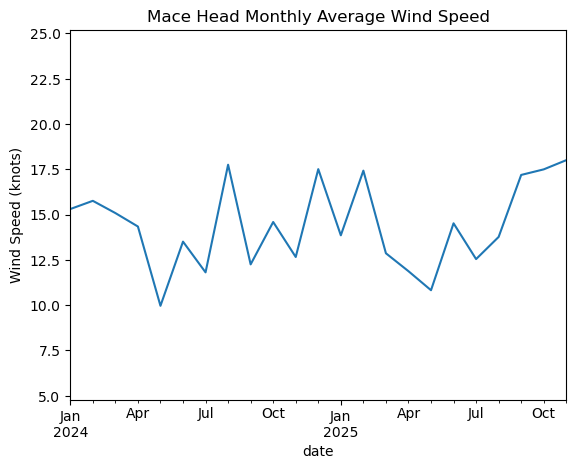

In [11]:
mace_head_wdsp_resampled.plot(title='Mace Head Monthly Average Wind Speed')
plt.ylabel('Wind Speed (knots)')
plt.xlim('2024-01-01', '2025-11-01')
plt.show()
plt.close()

## Machine Learning

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.geeksforgeeks.org/data-science/model-selection-for-arima/

In [12]:
mace_head_wdsp_resampled.head()

date
2003-08-01    11.921114
2003-09-01    11.996310
2003-10-01    12.225746
2003-11-01    17.668985
2003-12-01    13.298077
Freq: MS, Name: wdsp, dtype: float64

In [13]:
result = adfuller(mace_head_wdsp_resampled)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -4.160785
p-value: 0.000767
Series is stationary; no differencing needed.


https://stackoverflow.com/questions/52872724/convergencewarning-maximum-likelihood-optimization-failed-to-converge

I was getting a ConvergenceWarning, and upon investigation it was suggested to include a max iterations keyword argument in my `model.fit`.

C:\Users\luxxx\AppData\Local\Temp\ipykernel_24076\3717783597.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)


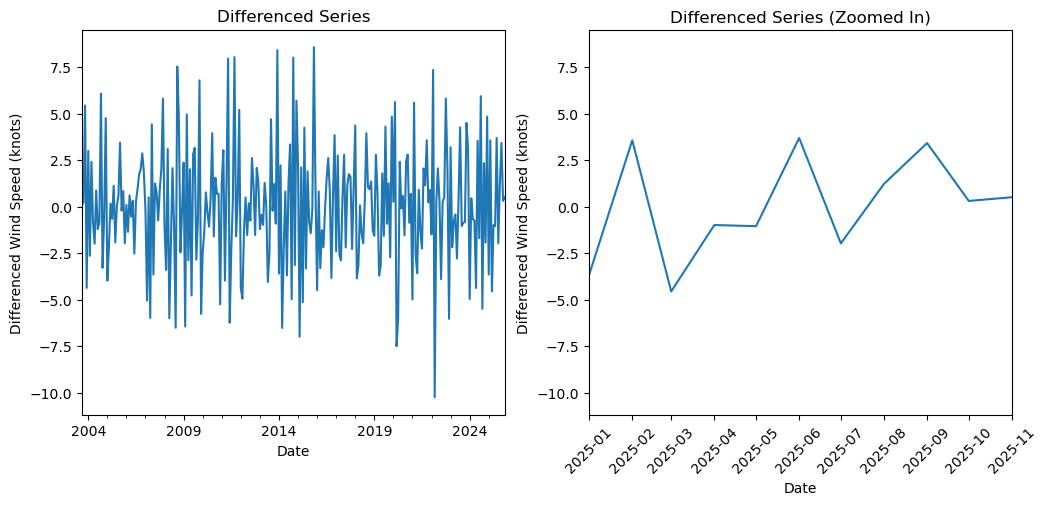

ADF Statistic (differenced): -10.643537
p-value (differenced): 0.000000


In [14]:
ts_diff = mace_head_wdsp_resampled.diff().dropna()

fig, axes = plt.subplots(1,2, figsize=(12,5))
ts_diff.plot(title='Differenced Series', ax=axes[0], ylabel='Differenced Wind Speed (knots)', xlabel='Date')
# ts_diff.plot(title='Differenced Series', ylabel='Differenced Wind Speed (knots)', xlabel='Date', ax=ax2, xlim=('2024-01-01', '2025-01-01'))
line = sns.lineplot(x=ts_diff.index, y=ts_diff.values, ax=axes[1])
axes[1].set_xlim(dt.datetime(2025, 1, 1), dt.datetime(2025, 11, 1))
axes[1].set(title='Differenced Series (Zoomed In)', ylabel='Differenced Wind Speed (knots)', xlabel='Date')
axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)
plt.show()

result_diff = adfuller(ts_diff)
print('ADF Statistic (differenced): %f' % result_diff[0])
print('p-value (differenced): %f' % result_diff[1])

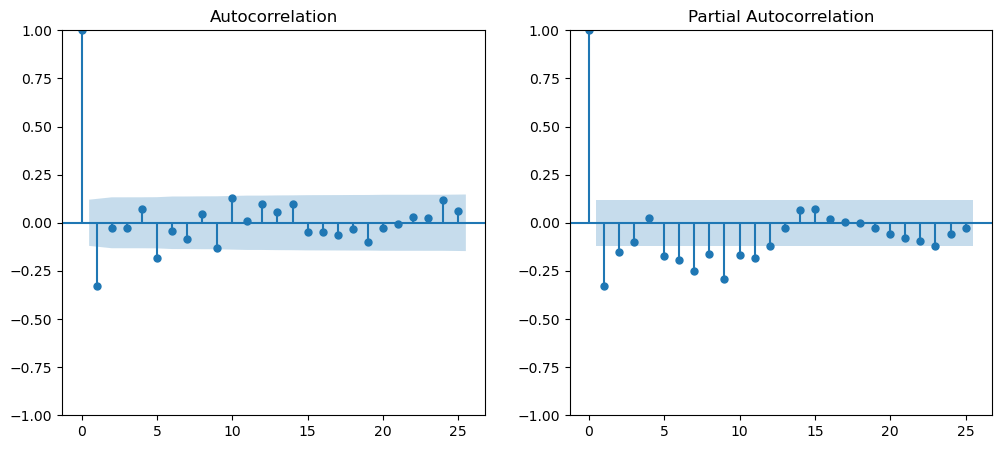

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
plt.show()

In [16]:
y_train_full, y_test = train_test_split(mace_head_wdsp_resampled, test_size=0.2, shuffle=False)

In [17]:
y_train, y_validation = train_test_split(y_train_full, test_size=0.2, shuffle=False)

In [18]:
p = range(0, 6)
d = [0]
q = range(0, 4)
s = [12]
pdqs = list(itertools.product(p, d, q, s))

best_aic = np.inf
best_order = None
best_model = None
lowest_rmse = np.inf
lowest_error_order = None

for order in pdqs:
    try:
        model = ARIMA(y_train, seasonal_order=order, enforce_stationarity=False, enforce_invertibility=False, trend='ct', freq='MS')
        results = model.fit(method_kwargs={'maxiter':300})
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
        rmse = sqrt(mean_squared_error(y_validation, results.forecast(steps=len(y_validation))))
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            lowest_error_order = order

    except Exception as e:
        print(f'Error for order {order}: {e}')
        

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')
print(f'Lowest RMSE order: {lowest_error_order} with RMSE: {lowest_rmse}')

Best ARIMA order: (5, 0, 3, 12) with AIC: 565.5795995499632
Lowest RMSE order: (1, 0, 1, 12) with RMSE: 2.381004254927634


We got the best fit with the highest values of our parameters, which is unsurpising, however we got the lowest error for the simplest model which is also unsurprising. The model will overfit to a more complex model meaning the predictions will be too close to our training data to effectively make predictions about the validation data. A simpler model, while running the risk of underfitting, has yielded the lowest mean squared error. I have to go with the parameters that yield the lowest error values. You can read more about the parameters P, D, Q [here](https://blog.milvus.io/ai-quick-reference/what-is-an-arima-pdq-model-and-what-do-the-parameters-represent).

In [19]:
model = ARIMA(y_train, seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False, trend='t', freq='MS')
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                     wdsp   No. Observations:                  171
Model:             ARIMA(1, 0, [1], 12)   Log Likelihood                -383.434
Date:                  Mon, 08 Dec 2025   AIC                            774.867
Time:                          00:07:58   BIC                            787.118
Sample:                      08-01-2003   HQIC                           779.842
                           - 10-01-2017                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0362      0.020      1.814      0.070      -0.003       0.075
ar.S.L12       0.9694      0.023     41.864      0.000       0.924       1.015
ma.S.L12      -1.0001     97.864    

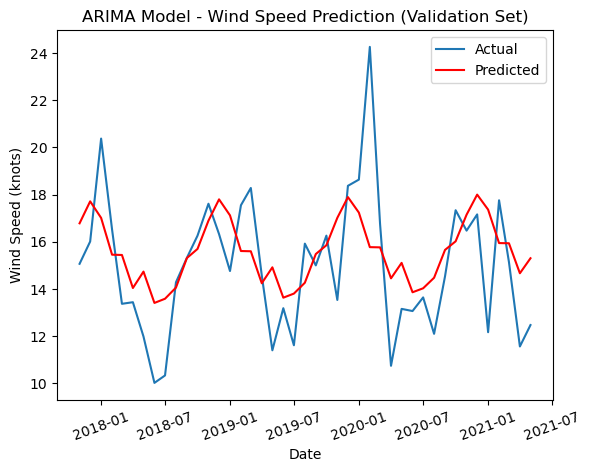

In [20]:
y_hat_validation = model_fit.forecast(steps=len(y_validation))
plt.plot(y_validation.index, y_validation, label='Actual')
plt.plot(y_validation.index, y_hat_validation, label='Predicted', color='red')
plt.title('ARIMA Model - Wind Speed Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.legend()

In [21]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 774.867354332178
BIC: 787.117734464286


In [22]:
rmse = np.sqrt(mean_squared_error(y_validation, y_hat_validation))
print(f"RMSE: {rmse:.4f}")

RMSE: 2.4445


Let's see how this stands up against the test set.

[This](https://www.geeksforgeeks.org/python/how-to-change-index-values-in-pandas/) resource helped me to set the correct index for the predicted values.

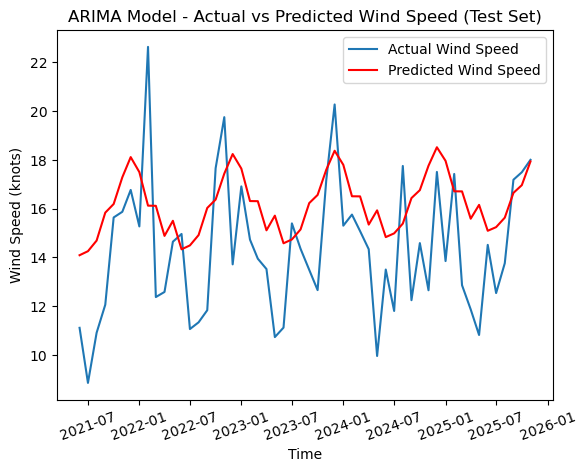

In [23]:
y_hat_test = pd.DataFrame(
    model_fit.forecast(
        steps=(len(y_test)+len(y_validation))
        )[len(y_validation):]
    ).set_index(y_test.index)
plt.plot(y_test, label='Actual Wind Speed')
plt.plot(y_hat_test, color='red', label='Predicted Wind Speed')
plt.title('ARIMA Model - Actual vs Predicted Wind Speed (Test Set)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.show()

In [24]:
print(f'RMSE for test set: {sqrt(mean_squared_error(y_test, y_hat_test))}')

RMSE for test set: 2.985666210437233


It seems that the periodicity has been captured very well but the highs and lows have not been predicted particularly well and our RMSE is in fact higher than with our validation set.

It is bad practice to use the test set to tune parameters so I will leave the exploration there and resist the urge to tune my parameters further.

seaborn relplot
distribution of averages, by month, is it normal mean and variance of each month, year
t test to see if months are the same or different
strip plots seaborn
box plots
